## Loading Data via Zarr Endpoints

* Zarr Format Benefits:

    * Scalable, flexible
    * Easy to access via HTTP/HTTPS in cloud storage

* But:

    * Majority of datasets in HDF5 (netCDF4)
    * HDF5/netCDF4 hard to access via HTTP/HTTPS in cloud storage

* Freva Solution:

    * REST API streams any file format as Zarr
    * Zarr protocol endpoints accessible via any Zarr library

### Workflow
* Search netCDF4 datasets using Freva-REST API
* Access data through Zarr endpoints

Let's define the search parameters for the Freva-REST API and import what we need

In [10]:
search_params = {"dataset": "cmip6-fs", "project": "cmip6"} # Define our search parameters
url = "http://localhost:7777" # URL of our test server.
from getpass import getpass
import requests
from tempfile import NamedTemporaryFile
import xarray as xr

If we normally search for data we will get the locations of the netCDF files on the hard-drive:

In [11]:
list(requests.get(
    "https://www.freva.dkrz.de/api/databrowser/data_search/freva/file", 
    params={"project":"reanalysis", "realm":"land", "time_frequency":"fx", "variable":"cvl"}, 
    stream=True
).iter_lines(decode_unicode=True))

['/work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/fx/land/cvl/r1i1p1/cvl_fx_reanalysis_era5_r1i1p1_19400101-20301231.nc']

What if the data location is not directly accessible, because it's stored somewhere else, like on tape? 
 * We can use the `load` endpoint to stream stream the data as Zarr data.

**Caveat**: Because the data can be accessed from anywhere once it is made available via zarr we need to create an *access token*:

In [14]:
auth = requests.post(
    f"https://www.freva.dkrz.de/api/auth/v2/token",
    data={"username": "k204230", "password":getpass("Password: ")}
).json()

Password:  ········


### "Order" the zarr datasets.
With this access token we can generate zarr enpoints to stream the data from anywhere, to do so we simply search for the datasets again:

In [24]:
res = requests.get(
    f"https://www.freva.dkrz.de/api/databrowser/load/freva", 
    params={"project":"reanalysis", "realm":"land", "time_frequency":"fx", "variable":"cvl"}, 
    headers={
        "Authorization": f"Bearer {auth['access_token']}"
    },
    stream=True
)

This will search for data and for every found entry create a zarr endpoint that can be loaded:

In [25]:
zarr_files = list(res.iter_lines(decode_unicode=True))
zarr_files

['https://www.freva.dkrz.de/api/freva-data-portal/zarr/e3f9f88f-4898-5916-b6c2-2ae1fd90f87a.zarr']

### Open the zarr datasets

Let's load the data with xarray and zarr:

In [26]:
dset = xr.open_dataset(
    zarr_files[0],
    engine="zarr",
    chunks="auto", 
    storage_options={"headers": {"Authorization": f"Bearer {auth['access_token']}"}}
)
dset

<xarray.Dataset>
Dimensions:   (time: 1, lat: 640, lon: 1280, bnds: 2)
Coordinates:
  * lat       (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
  * lon       (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * time      (time) datetime64[ns] 2000-01-01
Dimensions without coordinates: bnds
Data variables:
    cvl       (time, lat, lon) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(640, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(1280, 2), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Fri Jan 05 10:17:08 2024: cdo -s -f nc4 -z zip_9 -seltime...
    institution:    European Centre for Medium-Range Weather Forecasts
    Conventions:    CF-1.6
    tracking_id:    d5b13485-16f3-5f65-8dfd-cf03615bcc01
    creation_date:  2020-10-09T18:03:10Z
    license:        Contains modified Copernicus Atmosphere Monitoring Servic...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...

We do have a xarray dataset, meaning we can just proceed with our analysis:

In [30]:
dset["cvl"]

<xarray.DataArray 'cvl' (time: 1, lat: 640, lon: 1280)>
dask.array<open_dataset-cvl, shape=(1, 640, 1280), dtype=float32, chunksize=(1, 640, 1280), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
  * lon      (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * time     (time) datetime64[ns] 2000-01-01
Attributes:
    standard_name:  vegetation_area_fraction
    long_name:      Low Vegetation Cover
    units:          %
    code:           27
    table:          128
    original_name:  var27

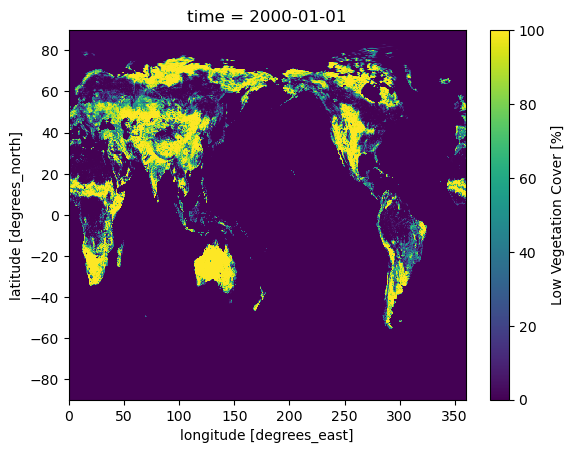

In [31]:
dset["cvl"].isel(time=0).plot()

## Creating intake catalogues
Intake can conviniently aggregate data. Instead creating individual lists of files we can create an intake catalogue with the zarr end points that helps us to aggregate the data later.

To create an intake catalogue instead of a list of files we simply have to add the `catalogue-type:intake` search parameter:

In [8]:
import intake
search_params["catalogue-type"] = "intake"
res = requests.get(
    f"{url}/api/databrowser/load/freva", 
    params=search_params, 
    headers={
        "Authorization": f"Bearer {auth['access_token']}"
    },
    stream=True
)

In [9]:
with NamedTemporaryFile(suffix=".json") as temp_f:
    with open(temp_f.name, "w") as stream:
        stream.write(res.text)
    cat = intake.open_esm_datastore(temp_f.name)
cat.df

,uri,project,product,institute,model,experiment,time_frequency,realm,variable,ensemble,cmor_table,fs_type,grid_label
0,http://localhost:7777/api/freva-data-portal/za...,CMIP6,CMIP,MPI-M,MPI-ESM1-2-LR,amip,mon,atmos,ua,r2i1p1f1,Amon,posix,gn
1,http://localhost:7777/api/freva-data-portal/za...,CMIP6,CMIP,CSIRO-ARCCSS,ACCESS-CM2,amip,mon,atmos,ua,r1i1p1f1,Amon,posix,gn


## Using the freva client libray
Rest requests can be confusing for many users. The new `freva_client` library is here to help

In [14]:
from freva_client import authenticate, databrowser
data_query = databrowser(dataset="cmip6-fs", host="localhost:7777", stream_zarr=True)
token = authenticate(username="janedoe", host="localhost:7777")
files = list(data_query)
files

Give password for server authentication:  ········


['http://localhost:7777/api/freva-data-portal/zarr/dcb608a0-9d77-5045-b656-f21dfb5e9acf.zarr',
 'http://localhost:7777/api/freva-data-portal/zarr/f56264e3-d713-5c27-bc4e-c97f15b5fe86.zarr']

We can also use the freva client library to directly create an intake catalogue:

In [15]:
cat = data_query.intake_catalogue()
cat.df

,uri,project,product,institute,model,experiment,time_frequency,realm,variable,ensemble,cmor_table,fs_type,grid_label
0,http://localhost:7777/api/freva-data-portal/za...,CMIP6,CMIP,MPI-M,MPI-ESM1-2-LR,amip,mon,atmos,ua,r2i1p1f1,Amon,posix,gn
1,http://localhost:7777/api/freva-data-portal/za...,CMIP6,CMIP,CSIRO-ARCCSS,ACCESS-CM2,amip,mon,atmos,ua,r1i1p1f1,Amon,posix,gn


## How does it work?
<img src="outline.jpg" alt="image" width="50%">

## What's next?
- Add json payload to `load` endpoint that allows the users to pre-precess data. For example select a region by uploading a geojson shape file.
- Implement a backend handle to open tape archives